<a href="https://colab.research.google.com/github/Pabloherreroo/Facial-Expression-Recognition_UsingML/blob/main/group40_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Recognition from Facial Expressions

Group 40: Alvaro Menéndez Ros, Juan José Leguineche Gallego, Pablo Herrero Ortiz

## 1. Introduction

This project implements an **Emotion Recognition system** using facial image data to classify human emotions based on visual expressions. The system is designed to detect and interpret emotions such as happiness, sadness, anger, surprise, fear, disgust, and neutrality. The solution follows a complete machine learning pipeline, integrating computer vision and classification techniques to operate on image data from both static datasets and live camera input.

1. **Data acquisition and preparation**: Facial expression data is obtained from the FER2013 dataset, which contains grayscale images labeled with emotion categories. The data is explored, reshaped, and preprocessed to handle class imbalance and prepare it for feature extraction and model training.
2. **Feature engineering**: Meaningful visual features are extracted from the images, exploring different strategies to achieve robust and efficient representations.
3. **Learning methods**: The machine learning models trained and evaluated are Support Vector Machines (SVM), Multi-Layer Perceptrons (MLP), Random Forests and Fuzzy Systems.
4. **Model comparison and analysis**: All approaches are compared, identifying optimal models and features. The best-performing model is deployed in a real-time demo (in an additional python file) that captures video from a laptop camera, detects faces and classifies the displayed emotion.

The notebook is structured to reflect this workflow step by step. While it is divided into more detailed sections, they all contribute to the four stages defined above.  

### 1.1. Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To run this notebook, several libraries are needed. The code cell below gathers all required imports.

**Required Installations:** Python (3.13.5), numpy (2.2.6), pandas (2.3.2), matplotlib (3.10.6), opencv-python (4.12.10)...

*Note: Versions in previous list are those used for the execution. While older versions may still work, compatibility cannot be fully guaranteed.*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix

## 2. Data Acquisition and Visualization

This section focuses on obtaining the raw dataset and performing initial visualizations to guide the preprocessing stage.

As mentioned previously, the project uses the FER2013 dataset, which contains grayscale images of facial expressions labeled within seven emotion categories: angry, disgust, fear, happy, sad, surprise, and neutral. The dataset is available as a single .csv file from Kaggle, where each image is represented as a sequence of pixel intensity values alongside its corresponding emotion label.

The dataset contains predefined training, public test, and private test splits, which are preserved for consistent evaluation. After loading, several visualizations are generated to gain an initial understanding of the data distribution and quality. These analyses support informed decisions for preprocessing steps.

In the following cell, the data path (constant) is defined and the dataframe obtained. After, there is also a short visualization of the first five rows to illustrate the format.

In [3]:
import kagglehub
import shutil
from pathlib import Path

def download_and_move_dataset():
    try:
        path = kagglehub.dataset_download("deadskull7/fer2013")
        print("Downloaded to cache:", path)

        # Target directory
        target_dir = Path.cwd() / "data"

        # Move the dataset folder
        shutil.move(path, target_dir)
        print("Moved to:", target_dir)
    except:
        print("Dataset not found. Please download 'fer2013.csv' from Kaggle and place it in this directory.")

In [4]:
import os
import shutil

DATA_PATH = "data/1/fer2013.csv" if os.path.exists("data/1/fer2013.csv") else "data/fer2013.csv"
DRIVE_PATH = "/content/drive/MyDrive/fer2013.csv"

os.makedirs("data", exist_ok=True)

if not os.path.exists(DATA_PATH):
    if os.path.exists(DRIVE_PATH):
        print("Dataset found in Google Drive. Copying to local directory...")
        shutil.copy2(DRIVE_PATH, DATA_PATH)
        print("Dataset successfully copied!")
    else:
        print("Dataset not found locally or in Drive. Downloading...")
        download_and_move_dataset()
else:
    print("Dataset already exists locally.")

Dataset already exists locally.


In [5]:
df = pd.read_csv(DATA_PATH)

In [6]:
print("Dataset shape (rows, cols):", df.shape)
df.head()

Dataset shape (rows, cols): (35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### 2.1. Usage and emotion distribution

The columns of the dataset can be described as follows:
- emotion: Integer label from 0 to 6 for the seven emotion classes.
- pixels: string of 2304 (48x48) space separated pixel values of the image.
- Usage: Indicates with a string whether the sample belongs to the Training, PublicTest, or PrivateTest split

The usage split, as mentioned, should be 80% for training data, 10% for public test (validation) and 10% for private test. This distribution is now checked with a plot.

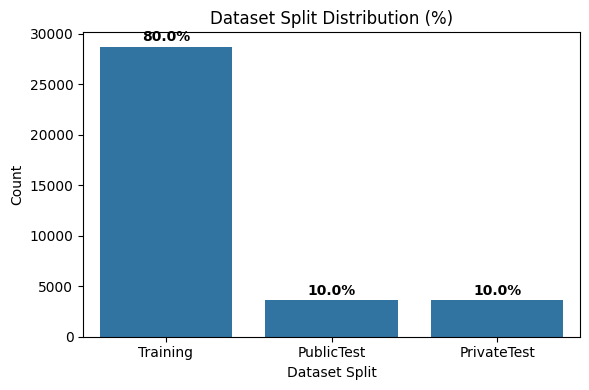

In [7]:
split_counts = df['Usage'].value_counts()
split_perc = 100 * split_counts / split_counts.sum()

split_df = pd.DataFrame({'Count': split_counts, 'Percentage': split_perc})

plt.figure(figsize=(6,4))
ax = sns.barplot(x=split_df.index, y='Count', data=split_df)

for i, (count, perc) in enumerate(zip(split_df['Count'], split_df['Percentage'])):
    ax.text(i, count + max(split_df['Count']) * 0.01, f'{perc:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Dataset Split Distribution (%)")
plt.xlabel("Dataset Split")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Now, the code provided in the assignment to split the dataset and store it in different csv files is executed. All plotting done onwards will be done with only train data to avoid data leakage.

In [8]:
trai_df = df[df['Usage']== 'Training'].copy()
vali_df = df[df['Usage'] == 'PublicTest'].copy()
test_df = df[df['Usage'] == 'PrivateTest'].copy()

trai_df.to_csv("./data/fer2013_train.csv", encoding='utf-8', index=False)
vali_df.to_csv("./data/fer2013_validation.csv", encoding='utf-8', index=False)
test_df.to_csv("./data/fer2013_test.csv", encoding='utf-8', index=False)

It can be assumed that images across all dataset partitions (training, public test, and private test) do not present significant visual differences. Therefore, plotting sample images by Usage label was considered unnecessary.

Regarding emotions, the distribution is reportedly unequal amongst classes. Therefore, after an emotion mapping based on dataset information, the count of images per emotion will be plotted to illustrate the differences. Later, some sample images will be reconstructed using NumPy arrays for each emotion.

In [9]:
emotion_labels = {
    0:'0: Angry',
    1:'1: Disgust',
    2:'2: Fear',
    3:'3: Happy',
    4:'4: Sad',
    5:'5: Surprise',
    6:'6: Neutral'
}

<Figure size 800x500 with 0 Axes>

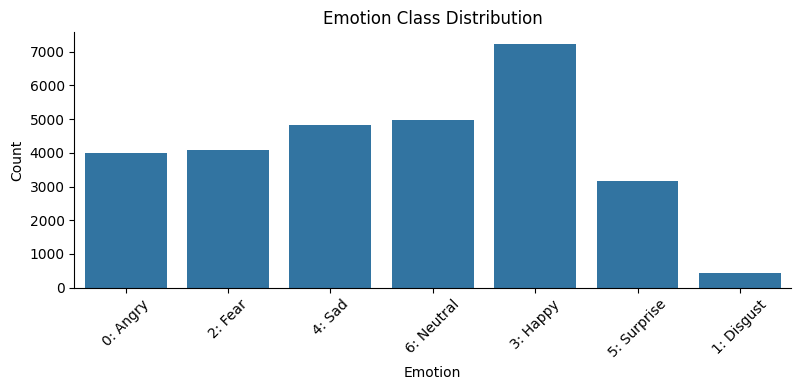

In [10]:
plt.figure(figsize=(8,5))
sns.catplot(data=trai_df.replace({'emotion': emotion_labels}), kind='count', x='emotion', height=4, aspect=2)
plt.title("Emotion Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

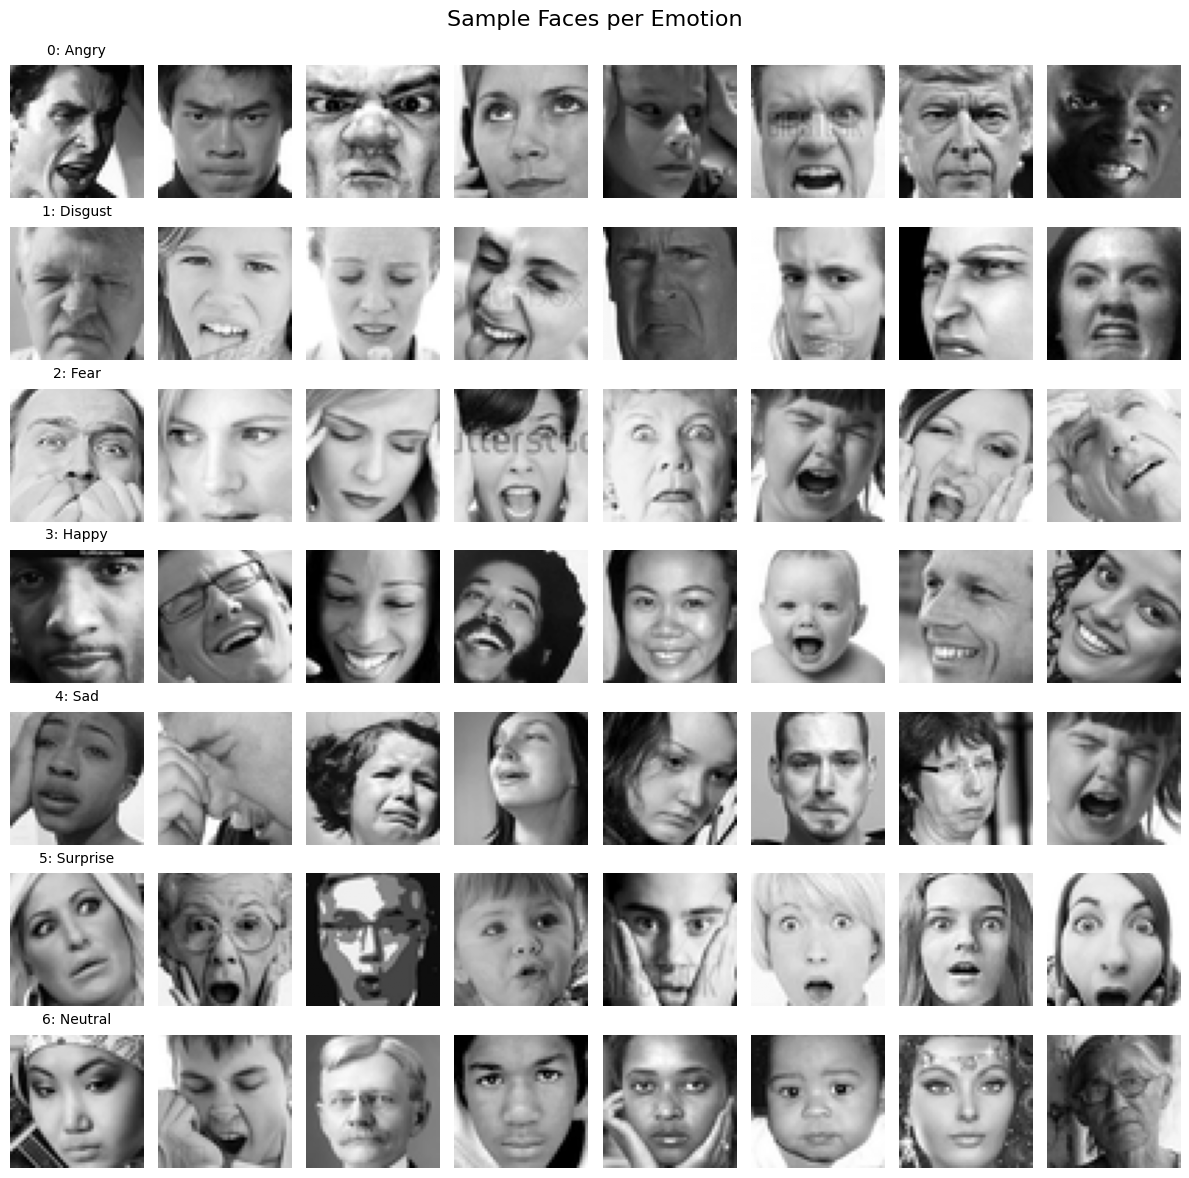

In [11]:
fig, axes = plt.subplots(7, 8, figsize=(12, 12))
fig.suptitle("Sample Faces per Emotion", fontsize=16)

for i, (emotion, group) in enumerate(trai_df.groupby('emotion')):
    samples = group.sample(8, random_state=42)
    for j, pixels in enumerate(samples['pixels']):
        img = np.array(pixels.split(), dtype='uint8').reshape(48, 48)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(emotion_labels[emotion], fontsize=10, pad=8)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

In some cases, differences between classes are clear to the human eye, although that is not always true. Most expressions contain samples that can appear very similar (*"Disgust"* and *"Angry"*, *"Surprise"* and *"Fear"*), especially given the low resolution and grayscale format. As even humans may disagree on certain labels, misclassifications with machine learning models are expected.

This visual overlap means that low accuracies will be the norm, having difficulties to categorize the majority of them correctly. To improve the performance as much as possible, it is important to define robust feature extraction and data preprocessing steps, which help better separate classes in the feature space.

### 2.2. Brightness distribution

The following plots explore the distribution of average pixel brightness across the dataset and per emotion.
They help identify whether lighting or exposure differences could bias emotion classification.

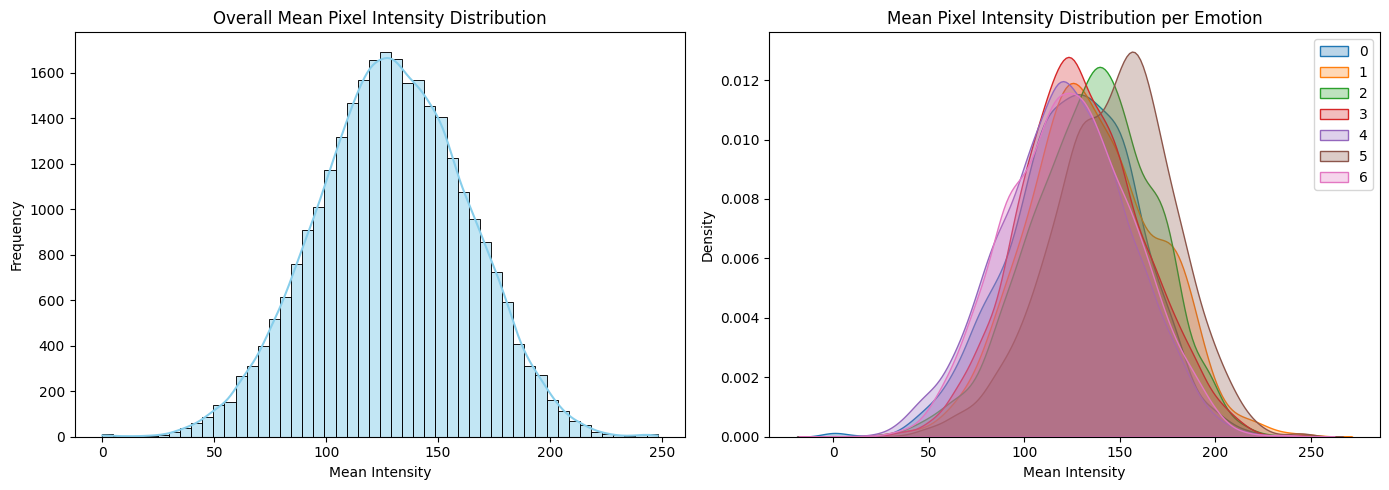

In [12]:
means = trai_df['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=int).mean())

fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(means, kde=True, bins=50, color='skyblue', ax=axes[0])
axes[0].set_title("Overall Mean Pixel Intensity Distribution")
axes[0].set_xlabel("Mean Intensity")
axes[0].set_ylabel("Frequency")

for emotion, group in trai_df.groupby('emotion'):
    # Instead of plotting overall frequencies, use density as classes have different sizes
    subset_means = group['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=int).mean())
    sns.kdeplot(subset_means, label=emotion, fill=True, alpha=0.3, ax=axes[1])

axes[1].set_title("Mean Pixel Intensity Distribution per Emotion")
axes[1].set_xlabel("Mean Intensity")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.show()

The overall distribution is roughly normal, centered around mid-gray (120-130) values, which indicates balanced brightness. Knowing this, a simple global normalization (such as scaling the pixel values) should be sufficient to handle illumination.

Regarding emotions, all of them show overlapping intensity profiles, meaning brightness alone does not discriminate enough. This, which could be partially appreciated visually in the previous images, indicates that feature extraction must focus in capturing more complex facial patterns.

### 2.3. Average face and pixel variance per emotion

The first plot of this section shows the average face computed for each emotion by taking the mean pixel intensities across multiple samples. It can provide a quick overview of how facial structures differ (or overlap) between emotions and highlights the visual patterns.

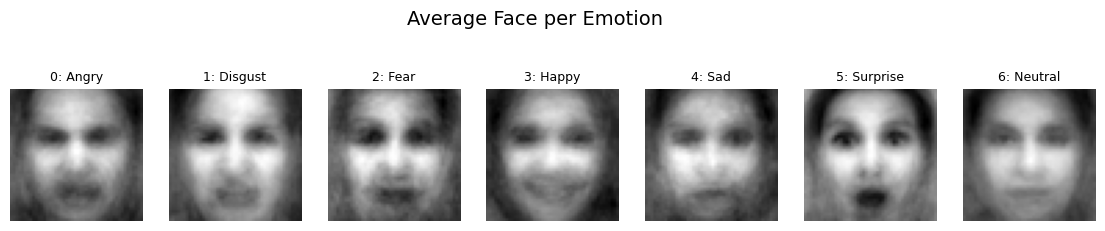

In [13]:
avg_faces = {}
for emotion, group in trai_df.groupby('emotion'):
    imgs = np.stack(group['pixels'].sample(200, random_state=42).apply(lambda x: np.fromstring(x, sep=' ', dtype=int)))
    avg_faces[emotion_labels[emotion]] = imgs.mean(axis=0).reshape(48, 48)

fig, axes = plt.subplots(1, 7, figsize=(14, 3))
for i, (emotion, img) in enumerate(avg_faces.items()):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(emotion, fontsize=9)
    axes[i].axis('off')
plt.suptitle("Average Face per Emotion", fontsize=14)
plt.show()


It can be seen that some subtle distinctions appear, such as open mouths and eyes for *"Surprise"* and *"Fear"* or curved mouths for *"Happy"*. However, most other facial features appear visually similar, and the limited resolution makes detailed comparisons difficult.

Overall, the overlap confirms that, in many emotions, facial differences are very subtle, proving the challenging nature of classification.

As the last visualization, a boxplot to analyze the variance of pixel intensities per emotion has been created. It helps identify whether certain emotions contain noisier or more homogeneous samples.

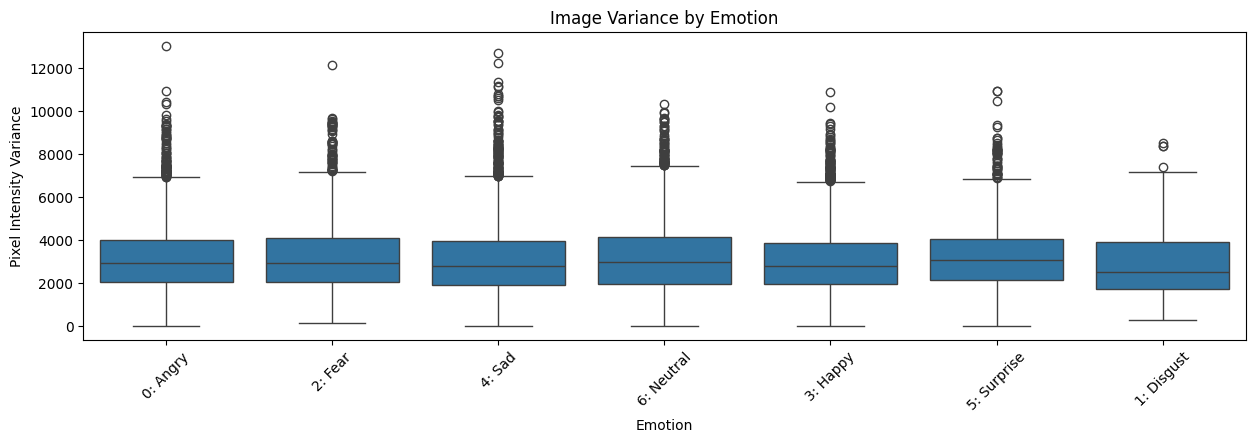

In [14]:
variances = trai_df.assign(variance=trai_df['pixels'].apply(lambda x: np.var(np.fromstring(x, sep=' ', dtype=int))))
plt.figure(figsize=(15,4))
sns.boxplot(x='emotion', y='variance', data=variances.replace({'emotion': emotion_labels}))
plt.title("Image Variance by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Pixel Intensity Variance")
plt.xticks(rotation=45)
plt.show()

Median variances are similar across all emotions, further indicating the comparable contrast levels and lighting conditions across the dataset.

However, there is an abundance of high-variance outliers, which indicates inconsistent image quality. This is possibly due to differences in face positioning, illumination, or expression intensity.
It reinforces the need for preprocessing steps like normalization or augmentation to mitigate variability and improve robustness.

## 3. Utils


Helper methods to:
- Get independent and dependent variables (pixels and emotion) from a DataFrame instance
- Show an image from an instance (e.g. show_image(df.iloc[0]))
- Decorator to measure training time of models

This will be useful later


Emotion of instance: 0: Angry


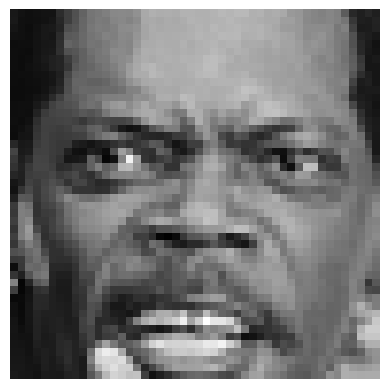

In [15]:
import time
from contextlib import contextmanager

# Both methods handle both single rows and regular instances (df.iterrows() and df.iloc[])
def get_pixels(instance):
    pixels_str = instance["pixels"] if hasattr(instance, "pixels") else instance[1]["pixels"]
    pixels = [int(number) for number in pixels_str.split(" ")]
    return pixels

def get_emotion(instance):
    return instance["emotion"] if hasattr(instance, "emotion") else instance[1]["emotion"]

def show_image(instance):
    pixels = get_pixels(instance)
    image = np.array(pixels).reshape((48, 48))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

@contextmanager
def my_timer(description):
    print(f"{description}...")
    start_time = time.time()
    try:
        yield
    finally:
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training time: {training_time:.1f} seconds")

# TESTING
n=10
instance = df.iloc[n] # also works with df.iterrows()
pixels = get_pixels(instance)
emotion = get_emotion(instance)
print(f"Emotion of instance: {emotion_labels[emotion]}")
show_image(instance)


Check that all images are 48*48

In [16]:
def check_pixel_length(df):
    for instance in df.iterrows():
        pixels = get_pixels(instance)
        assert len(pixels) == 2304 # EACH IMAGE HAS 2304 PIXELS

# Check pixel length for each dataset
for df in [trai_df, vali_df, test_df]:
    check_pixel_length(df)

## 4. Model definitions

Abstract class to make predictions - Create different classes to implement different prediction methods.

In [17]:
from abc import ABC, abstractmethod

class BaseModel(ABC):

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)


### 4.1 Models to use

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

class RandomForestModel(BaseModel):
    def __init__(self, n_estimators=50, max_depth=10,min_samples_leaf=5, random_state=42, verbose=0, n_jobs=-1):
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            verbose=verbose,
            n_jobs=n_jobs
        )

class SVMModel(BaseModel):
    def __init__(self, C=0.1, random_state=42, max_iter=1000):
        self.model = LinearSVC(
            C=C,
            class_weight='balanced',
            random_state=random_state,
            verbose=0,
            max_iter=max_iter,
            dual='auto'
        )

class MLPModel(BaseModel):
    def __init__(self, hidden_layer_sizes=(100,), batch_size=256, max_iter=200, random_state=42):
        self.model = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            batch_size=batch_size,
            activation='relu',
            solver='adam',
            max_iter=max_iter,
            random_state=random_state,
            verbose=False,
            early_stopping=True
        )

### TODO: Implement fuzzy systems

## 5. Evaluation pipeline

Evaluate a model on a dataset:

`predict_dataset(model, df)`:
- Predict the emotions for the entire dataset in a single batch

`evaluate_model(model, df)`:
- Calculate the balanced accuracy using sklearn

In [19]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import random
from tqdm import tqdm

def predict_instance(model, instance):
    pixels = get_pixels(instance)
    # Wrap the single list of pixels in another list/array
    # to create a 2D array of shape (1, 2304)
    pixels_batch = np.array([pixels])
    prediction = model.predict(pixels_batch)
    return prediction

def predict_dataset(model, df):
    """
    Returns list of predictions and list of actual values.
    """
    # Prepare all pixel data into a 2D NumPy array.
    pixels_list = df['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=int))
    X_test = np.vstack(pixels_list.values)

    actual = df['emotion'].values

    predictions = model.predict(X_test)

    return predictions, actual

def evaluate_model(model, df, confusion=False):
    predictions, actual = predict_dataset(model, df)
    accuracy = balanced_accuracy_score(actual, predictions)
    if confusion:
        cm = confusion_matrix(actual, predictions)
        class_names = list(emotion_labels.values())
        model_name = model.__class__.__name__
        plot_confusion_matrix(cm, model_name, accuracy, class_names)
    else:

        print(f"Balanced accuracy: {accuracy*100:.1f}%")

def plot_confusion_matrix(cm, model_name,accuracy, class_names=[]):
    plt.figure(figsize=(4, 3))

    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    annot_kws={'size': 10, 'weight': 'bold'},
                    cbar=False,
                    square=True)

    plt.xlabel('Predicted', fontsize=11, fontweight='bold')
    plt.ylabel('True', fontsize=11, fontweight='bold')
    plt.title(f'Confusion Matrix for {model_name}', fontsize=11, fontweight='bold')
    plt.xticks([])
    plt.yticks(fontsize=9, rotation=0, weight='bold')

    ax.set_xticklabels(ax.get_xticklabels(), weight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), weight='bold')

    ax.yaxis.set_label_position("right")

    plt.tight_layout()
    total = np.sum(cm)
    print(f"Balanced accuracy: {accuracy*100:.1f}%")

In [20]:
def predict_random_instance(df, model, emotion_labels):
    n = random.randint(0, len(df) - 1)
    instance = df.iloc[n]
    prediction = predict_instance(model, instance)
    predicted_index = np.array(prediction).item()
    true_emotion = get_emotion(instance)
    print(f"Prediction: {emotion_labels[predicted_index]}, Actual: {emotion_labels[true_emotion]}")
    show_image(instance)

### 5.1 Generate training data

In [21]:
def get_train_data():
    X_train = []
    y_train = []
    for instance in trai_df.iterrows():
        pixels = get_pixels(instance)
        emotion = get_emotion(instance)
        X_train.append(pixels)
        y_train.append(emotion)
    return X_train, y_train

In [22]:
X_train, y_train = get_train_data()
X_train = np.array(X_train)
y_train = np.array(y_train)

In [23]:
print(f"len(X_train): {len(X_train)}, len(y_train): {len(y_train)}")

len(X_train): 28709, len(y_train): 28709


## 6. Preprocessing, feature extraction/selection, data normalizing, augmentation

### 6.1 Data Normalizing

In [24]:
from sklearn.preprocessing import StandardScaler

def normalize_data(X_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    return scaler, X_train_scaled

In [25]:
scaler, X_train_scaled = normalize_data(X_train)

In [26]:
class NormalizedModel(BaseModel):
    """
    A wrapper model that includes scaling and a final model.
    """
    def __init__(self, scaler, model):
        self.scaler = scaler
        self.model = model

    def fit(self, X, y):
        X_scaled = self.scaler.transform(X)
        self.model.fit(X_scaled, y)
        return self

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)

### 6.2 PCA

In [27]:
from sklearn.decomposition import PCA

# Apply PCA to ALL training data (using scaler and X_train_scaled from before)
# By not setting n_components, we compute all components to see how much variance they explain.
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

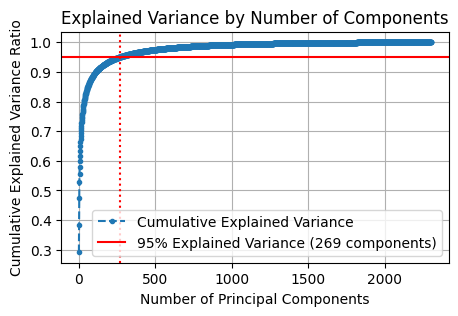


Number of components needed to explain 95% of variance: 269


In [28]:
# Calculate the cumulative sum of explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='.', linestyle='--', label='Cumulative Explained Variance')
plt.title("Explained Variance by Number of Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid(True)

# Find the number of components to explain 95% of the variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
plt.axhline(y=0.95, color='r', linestyle='-', label=f'95% Explained Variance ({n_components_95} components)')
plt.axvline(x=n_components_95, color='r', linestyle=':')
plt.legend(loc='best')
plt.show()

print(f"\nNumber of components needed to explain 95% of variance: {n_components_95}")

In [29]:
class PCAPipelineModel(BaseModel):
    """
    A wrapper model that includes scaling, PCA, and a final model.
    """
    def __init__(self, scaler, pca, model):
        self.scaler = scaler
        self.pca = pca
        self.model = model

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        X_pca = self.pca.transform(X_scaled)
        return self.model.predict(X_pca)

    def fit(self, X, y):
      X_scaled = self.scaler.transform(X)
      X_pca = self.pca.transform(X_scaled)
      self.model.fit(X_pca, y)
      return self

In [30]:
pca_reduced = PCA(n_components=n_components_95)
X_train_pca_reduced = pca_reduced.fit_transform(X_train_scaled)

### 6.3 Feature Extraction


#### 6.3.1 Local Binary Patterns (LBP)

In [31]:
from skimage import feature
import numpy as np

def get_lbp_features(pixels):
    """
    Computes the Local Binary Patterns histogram for a single image.
    """
    image = np.array(pixels).reshape((48, 48))

    # LBP parameters: 24 neighbors, 8 radius
    lbp = feature.local_binary_pattern(image, P=24, R=8, method="uniform")

    # Calculate the histogram of the LBP image. This is our feature vector.
    # The number of bins is P + 2
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, 24 + 3),
                             range=(0, 24 + 2))

    # Normalize
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist

In [32]:
class LBPFeatureModel(BaseModel):
    """
    A wrapper model that computes LBP features before fitting/predicting.
    """
    def __init__(self, model):
        self.model = model

    def _extract_features(self, X):
        # Compute LBP features for each image in the batch
        return np.array([get_lbp_features(pixels) for pixels in X])

    def predict(self, X):
        print("Extracting LBP features for prediction...")
        X_lbp = self._extract_features(X)
        return self.model.predict(X_lbp)

    def fit(self, X, y):
        print("Extracting LBP features for training...")
        X_lbp = self._extract_features(X)
        self.model.fit(X_lbp, y)
        return self

In [33]:
X_train_lbp = np.array([get_lbp_features(pixels) for pixels in tqdm(X_train)])

100%|██████████| 28709/28709 [01:06<00:00, 434.19it/s]


#### 6.3.2 HOG features

In [34]:
from skimage.feature import hog

def get_hog_features(pixels):
    """
    Computes HOG (Histogram of Oriented Gradients) features for a single image.
    HOG captures edge and gradient structure, which is useful for facial expressions.
    """
    image = np.array(pixels).reshape((48, 48))
    features = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False,
        feature_vector=True
    )

    return features

class HOGFeatureModel(BaseModel):
    """
    A wrapper model that computes HOG features before making a prediction.
    """
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        print("Extracting HOG features for prediction...")
        X_hog = np.array([get_hog_features(pixels) for pixels in tqdm(X)])
        return self.model.predict(X_hog)

    def fit(self, X, y):
        print("Extracting HOG features for training...")
        X_hog = np.array([get_hog_features(pixels) for pixels in tqdm(X)])
        self.model.fit(X_hog, y)
        return self

In [35]:
print("Extracting HOG features from training data...")
X_train_hog = np.array([get_hog_features(pixels) for pixels in tqdm(X_train)])
print(f"HOG feature shape: {X_train_hog.shape}")

Extracting HOG features from training data...


100%|██████████| 28709/28709 [00:41<00:00, 695.28it/s]


HOG feature shape: (28709, 900)


#### 6.3.3 Add combined features

In [36]:
# Combine LBP and HOG features
print("Creating combined LBP+HOG features...")
X_train_combined = np.hstack([X_train_lbp, X_train_hog])
print(f"Combined feature shape: {X_train_combined.shape}")

# Normalize combined features
scaler_combined = StandardScaler()
X_train_combined_scaled = scaler_combined.fit_transform(X_train_combined)

# Apply PCA to combined features
pca_combined = PCA(n_components=0.95)
X_train_combined_pca = pca_combined.fit_transform(X_train_combined_scaled)
print(f"Combined features after PCA: {X_train_combined_pca.shape}")

class CombinedFeatureModel(BaseModel):
    """
    Model using both LBP and HOG features.
    """
    def __init__(self, scaler, pca, model):
        self.scaler = scaler
        self.pca = pca
        self.model = model

    def predict(self, X):
        print("Extracting combined features...")
        X_lbp = np.array([get_lbp_features(pixels) for pixels in tqdm(X)])
        X_hog = np.array([get_hog_features(pixels) for pixels in tqdm(X)])
        X_combined = np.hstack([X_lbp, X_hog])
        X_scaled = self.scaler.transform(X_combined)
        X_pca = self.pca.transform(X_scaled)
        return self.model.predict(X_pca)

    def fit(self, X, y):
        X_scaled = self.scaler.transform(X)
        X_pca = self.pca.transform(X_scaled)
        self.model.fit(X_pca, y)
        return self

Creating combined LBP+HOG features...
Combined feature shape: (28709, 926)
Combined features after PCA: (28709, 288)


### 6.4 Handling data Imbalance

As we saw in section 2, the dataset is highly imbalanced. The "Disgust" class is a severe minority class (around 450 samples) while "Happy" is the majority class (over 7000 samples).

In order to handle this data imbalance we will take two resampling techniques: Oversampling the minority class by creating synthetic samples (SMOTE) and Randomly removing samples from the classes with more instances (Undersampling)

In [37]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

original_counts = Counter(y_train)

# If a class count is > 3000, set its target to 3000.
# If it's <= 3000 (like 'Disgust'), leave it as-is.
undersample_strategy = {label: min(3000, count) for label, count in original_counts.items()}
undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)

# Oversample up to 3000 ('auto' handles this)
oversampler = SMOTE(sampling_strategy='auto', random_state=42)

hybrid_pipeline = ImbPipeline(steps=[('under', undersampler), ('over', oversampler)])
X_train_hybrid, y_train_hybrid = hybrid_pipeline.fit_resample(X_train_scaled, y_train)

unique, counts = np.unique(y_train_hybrid, return_counts=True)
print("Number of instances per class:")
for class_label, count in zip(unique, counts):
    print(f"{emotion_labels[class_label]}: {count}")


Number of instances per class:
0: Angry: 3000
1: Disgust: 3000
2: Fear: 3000
3: Happy: 3000
4: Sad: 3000
5: Surprise: 3000
6: Neutral: 3000


In [ ]:
pca_hybrid = PCA()
X_train_hybrid_pca_full = pca_hybrid.fit_transform(X_train_hybrid)

pca_hybrid_reduced = PCA(n_components=0.95)
X_train_hybrid_pca_reduced = pca_hybrid_reduced.fit_transform(X_train_hybrid)

print(f"Original hybrid data shape: {X_train_hybrid.shape}")
print(f"Shape after PCA reduction on hybrid data: {X_train_hybrid_pca_reduced.shape}")

## 7. Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.svm import LinearSVC
import numpy as np

balanced_acc_scorer = make_scorer(balanced_accuracy_score)

X_tune, _, y_tune, _ = train_test_split(
    X_train_hybrid_pca_reduced,
    y_train_hybrid,
    train_size=200,
    stratify=y_train_hybrid,
    random_state=42
)


print("\n1. Tuning Random Forest...")
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [2, 5, 10]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring=balanced_acc_scorer,
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_tune, y_tune)
print(f"Best RF params: {rf_grid.best_params_}")
print(f"Best RF score: {rf_grid.best_score_:.3f}")

print("\nTuning MLP...")
mlp_param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (200,), (200, 100)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

mlp_grid = GridSearchCV(
    MLPClassifier(max_iter=200, random_state=42, early_stopping=True),
    mlp_param_grid,
    cv=3,
    scoring=balanced_acc_scorer,
    verbose=1,
    n_jobs=-1
)

mlp_grid.fit(X_tune, y_tune)
print(f"Best MLP params: {mlp_grid.best_params_}")
print(f"Best MLP score: {mlp_grid.best_score_:.3f}")

print("\nTuning Linear SVM...")
svm_param_grid = {
    'C': [0.01, 0.1, 1.0],
    'max_iter': [500, 1000]
}

svm_grid = GridSearchCV(
    LinearSVC(random_state=42, class_weight='balanced', dual='auto'),
    svm_param_grid,
    cv=3,
    scoring=balanced_acc_scorer,
    verbose=1,
    n_jobs=-1
)

svm_grid.fit(X_tune, y_tune)
print(f"Best SVM params: {svm_grid.best_params_}")
print(f"Best SVM score: {svm_grid.best_score_:.3f}")

best_rf = rf_grid.best_estimator_
best_mlp = mlp_grid.best_estimator_
best_svm = svm_grid.best_estimator_

## 8. COOL PART... RESULTS

### 8.1 Model configs

In [ ]:
import joblib
from sklearn.metrics import classification_report

results = []

models_to_test = [
    ("Tuned RandomForest", best_rf),
    ("Tuned LinearSVM", best_svm),
    ("Tuned MLP", best_mlp)
]

configs = [
    {
        "name": "Raw Pixels (Scaled)",
        "X_data": X_train_scaled,
        "y_data": y_train,
        "pipeline_builder": lambda m: NormalizedModel(scaler=scaler, model=m)
    },
    {
        "name": "PCA (95%)",
        "X_data": X_train_pca_reduced,
        "y_data": y_train,
        "pipeline_builder": lambda m: PCAPipelineModel(scaler=scaler, pca=pca_reduced, model=m)
    },
    {
        "name": "SMOTE + PCA",
        "X_data": X_train_hybrid_pca_reduced,
        "y_data": y_train_hybrid,
        "pipeline_builder": lambda m: PCAPipelineModel(scaler=scaler, pca=pca_hybrid_reduced, model=m)
    },
    {
        "name": "LBP Features",
        "X_data": X_train,
        "y_data": y_train,
        "pipeline_builder": lambda m: LBPFeatureModel(model=m)
    },
    {
        "name": "HOG Features",
        "X_data": X_train,
        "y_data": y_train,
        "pipeline_builder": lambda m: HOGFeatureModel(model=m)
    },
    {
        "name": "LBP+HOG+PCA",
        "X_data": X_train,
        "y_data": y_train,
        "pipeline_builder": lambda m: CombinedFeatureModel(scaler=scaler_combined, pca=pca_combined, model=m)
    }
]


### 8.2 Evaluation Loop

In [ ]:
best_pipeline = None
best_test_acc = -1.0
best_model_name = ""

for config in configs:
    config_name = config["name"]
    X_data = config["X_data"]
    y_data = config["y_data"]

    print(f"Configuration: {config_name}")

    for model_name, model_instance in models_to_test:
        print(f"\n{model_name}:")
        pipeline = config["pipeline_builder"](model_instance)

        with my_timer(f"  Training"):
            # LBP/HOG/Combined wrappers take X_train, others take pre-processed data
            pipeline.fit(X_data, y_data)

        print("  Validation Set (Public Test):")
        val_preds, val_actual = predict_dataset(pipeline, vali_df)
        val_acc = balanced_accuracy_score(val_actual, val_preds)
        print(f"    Balanced Accuracy: {val_acc*100:.2f}%")

        print("  Test Set (Private Test):")
        test_preds, test_actual = predict_dataset(pipeline, test_df)
        test_acc = balanced_accuracy_score(test_actual, test_preds)
        print(f"    Balanced Accuracy: {test_acc*100:.2f}%")

        result_entry = {
            'Configuration': config_name,
            'Model': model_name,
            'Val Accuracy': val_acc,
            'Test Accuracy': test_acc
        }
        results.append(result_entry)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_pipeline = pipeline
            best_model_name = f"{model_name} ({config_name})"



print(f"\nBest model found: {best_model_name} with {best_test_acc*100:.2f}% test accuracy.")

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)
print(results_df.to_string(index=False))

plt.figure(figsize=(10, 5))
top_results = results_df.sort_values('Test Accuracy', ascending=True).tail(10)
x = range(len(top_results))
plt.barh(x, top_results['Test Accuracy'] * 100)
plt.yticks(x, [f"{row['Model']}\n({row['Configuration']})"
               for _, row in top_results.iterrows()], fontsize=8)
plt.xlabel('Balanced Accuracy (%)')
plt.title('Top 10 Model Configurations (Test Accuracy)')
plt.tight_layout()
plt.show()

## 9. Saving best model

In [ ]:
if best_pipeline:
    model_filename = "best_emotion_model.pkl"
    joblib.dump(best_pipeline, model_filename)
    print(f"\nSuccessfully saved best model to {model_filename}")

    print("\n--- Performance on Public Test Set ---")
    print(f"Best Model: {best_model_name}")
    evaluate_model(best_pipeline, vali_df, confusion=True)

    print("\n--- Performance on Private Test Set ---")
    print(f"Best Model: {best_model_name}")
    evaluate_model(best_pipeline, test_df, confusion=True)

else:
    print("\nNo model was successfully trained to save.")